In [2]:
import socket
import pickle
# import cloudpickle as pickle
import numpy as np
import tvm
from tvm import te
import tvm.relay as relay
from tvm.contrib.download import download_testdata
from tvm.contrib import graph_executor
import json
import time
import sys
import cv2
import struct
from argparse import ArgumentParser
import ntplib 
from multiprocessing import Process, Queue
import os
import matplotlib.pyplot as plt


In [3]:
args_model = 'unet'
args_target = 'cuda'
args_img_size = 512
args_opt_level = 3
# target and dev set
if args_target == 'llvm':
    target = 'llvm'
    dev = tvm.cpu()
elif args_target == 'cuda':
    target = 'cuda'
    dev = tvm.cuda()
elif args_target == 'opencl':
    target = 'opencl'
    dev = tvm.opencl()

In [4]:
NETWORK_WEIGHT = 0.00000000854636931
NETWORK_BAIS = 0.000004568534259
MODEL_TEST_TIME = 253
NETWORK_TEST_TIME = 1000
def network_cost(data_shape, data_type):
    data_size = 1
    for d in data_shape:
        data_size = data_size * d
    if data_type == 'float32':
        return 4 * data_size * NETWORK_WEIGHT + NETWORK_BAIS 
    elif data_type == 'int8':
        return data_size * NETWORK_WEIGHT + NETWORK_BAIS 
    else:
        return None

In [5]:
def get_model_info(partition_points):
    model_input_indexs = []
    model_output_indexs = []
    model_graph_json_strs = []

    # If there is no model to be executed
    if len(partition_points) == 1:
        return [partition_points], [partition_points], []

    # Load front model json infos
    for i in range(len(partition_points) - 1):
        start_point = partition_points[i]
        end_point = partition_points[i + 1]
        current_file_path = "./"
        with open(current_file_path + "../src/graph/{}_{}_{}_{}_{}-{}.json".format(args_model, args_target, args_img_size, args_opt_level, start_point, end_point), "r") as json_file:
            graph_json = json.load(json_file)
        input_indexs = graph_json['extra']["inputs"]
        output_indexs = graph_json['extra']["outputs"]
        
        model_input_indexs.append(input_indexs)
        model_output_indexs.append(output_indexs)
        del graph_json['extra']
        model_graph_json_strs.append(json.dumps(graph_json))

    return model_input_indexs, model_output_indexs, model_graph_json_strs


In [69]:
inin = """0,5|0.4465296268463135,0.23080182075500488,0.2945973873138428
0,11|0.4447143077850342,0.9883227348327637,0.29610323905944824
0,13|0.4348125457763672,1.172767162322998,0.445986270904541
0,19|0.42867136001586914,1.4520540237426758,0.47146153450012207
0,25|0.4285898208618164,1.9916508197784424,0.47199106216430664
0,27|0.42521023750305176,2.0849528312683105,0.5958976745605469
0,33|0.43041157722473145,2.3670644760131836,0.6302008628845215
0,39|0.4270193576812744,2.9183402061462402,0.6359305381774902
0,41|0.42575693130493164,2.9597408771514893,0.7193717956542969
0,47|0.4229545593261719,3.2427215576171875,0.7441356182098389
0,53|0.41953468322753906,3.7810380458831787,0.7117183208465576
0,55|0.41915345191955566,3.809504747390747,0.7852878570556641
0,61|0.41626572608947754,4.093234062194824,0.7933762073516846
0,72|0.42052507400512695,6.339616537094116,0.8277316093444824
0,73|0.4257633686065674,6.354682683944702,0.7559983730316162
0,79|0.42859911918640137,7.445481777191162,0.7382497787475586
0,90|0.4211084842681885,9.63137173652649,0.7570173740386963
0,91|0.4310615062713623,9.664386749267578,0.6669609546661377
0,97|0.42699384689331055,10.750640630722046,0.625032901763916
0,108|0.429044246673584,14.430463314056396,0.659797191619873
0,109|0.4322669506072998,14.497546434402466,0.587897777557373
0,115|0.43282556533813477,15.575836420059204,0.4911339282989502
0,126|0.4286339282989502,22.663426876068115,0.580000638961792
0,127|0.44910335540771484,22.783275604248047,0.4815511703491211
0,133|0.44570350646972656,24.343736171722412,0.29784297943115234
0,141|0.4355888366699219,25.339154720306396,0.1689610481262207"""
a = inin.split("\n")
d = []
infer_dict = {}
for info in a:
    src, dst = info.split('|')[0].split(',')
    infer_time = info.split('|')[1].split(',')[1]
    print(src, dst, float(infer_time))
    infer_dict["{}-{}".format(src, dst)] = float(infer_time)
    d.append(int(dst))
destinations = sorted(d)

0 5 0.23080182075500488
0 11 0.9883227348327637
0 13 1.172767162322998
0 19 1.4520540237426758
0 25 1.9916508197784424
0 27 2.0849528312683105
0 33 2.3670644760131836
0 39 2.9183402061462402
0 41 2.9597408771514893
0 47 3.2427215576171875
0 53 3.7810380458831787
0 55 3.809504747390747
0 61 4.093234062194824
0 72 6.339616537094116
0 73 6.354682683944702
0 79 7.445481777191162
0 90 9.63137173652649
0 91 9.664386749267578
0 97 10.750640630722046
0 108 14.430463314056396
0 109 14.497546434402466
0 115 15.575836420059204
0 126 22.663426876068115
0 127 22.783275604248047
0 133 24.343736171722412
0 141 25.339154720306396


In [112]:
server_data = """0,5|0.34996962547302246
0,11|0.5121638774871826
0,13|0.588925838470459
0,19|0.6701910495758057
0,25|0.7726650238037109
0,27|0.8159186840057373
0,33|0.8914945125579834
0,39|0.9934201240539551
0,41|1.0133213996887207
0,47|1.0853333473205566
0,53|1.1703181266784668
0,55|1.1873586177825928
0,61|1.280874252319336
0,72|2.060703992843628
0,73|2.0565340518951416
0,79|2.257066488265991
0,90|2.9114270210266113
0,91|2.8966686725616455
0,97|3.0954058170318604
0,108|3.9590346813201904
0,109|3.9419052600860596
0,115|4.096070051193237
0,126|5.504796743392944
0,127|5.496886968612671
0,133|5.700417757034302
0,141|5.855103492736816
5,11|0.9641928672790527
5,13|1.0323994159698486
5,19|1.1176788806915283
5,25|1.2230305671691895
5,27|1.2616395950317383
5,33|1.3362038135528564
5,39|1.4428184032440186
5,41|1.4609854221343994
5,47|1.5377027988433838
5,53|1.6355698108673096
5,55|1.6532156467437744
5,61|1.747957706451416
5,72|2.5092005729675293
5,73|2.4998064041137695
5,79|2.705293893814087
5,90|3.3741066455841064
5,91|3.348402738571167
5,97|3.5390360355377197
5,108|4.406180143356323
5,109|4.388651132583618
5,115|4.53596568107605
5,126|5.952430486679077
5,127|5.939438343048096
5,133|6.170241594314575
5,141|6.300531625747681
11,13|0.7101047039031982
11,19|0.8019378185272217
11,25|0.8924298286437988
11,27|0.9349203109741211
11,33|1.0062506198883057
11,39|1.1093552112579346
11,41|1.1364898681640625
11,47|1.19960355758667
11,53|1.3386163711547852
11,55|1.3301584720611572
11,61|1.4030916690826416
11,72|2.184650182723999
11,73|2.169719696044922
11,79|2.364994525909424
11,90|3.0346250534057617
11,91|3.0192983150482178
11,97|3.213852882385254
11,108|4.076070785522461
11,109|4.102110862731934
11,115|4.224223375320435
11,126|5.6511006355285645
11,127|5.772865056991577
11,133|6.008411645889282
11,141|6.163841962814331
13,19|0.28435754776000977
13,25|0.38848233222961426
13,27|0.42823052406311035
13,33|0.5009396076202393
13,39|0.6077821254730225
13,41|0.6352276802062988
13,47|0.7006747722625732
13,53|0.809847354888916
13,55|0.8646590709686279
13,61|0.9060342311859131
13,72|1.6797332763671875
13,73|1.676199197769165
13,79|1.8727242946624756
13,90|2.539294958114624
13,91|2.520761013031006
13,97|2.7182090282440186
13,108|3.5687971115112305
13,109|3.557691812515259
13,115|3.7080039978027344
13,126|5.107765197753906
13,127|5.950476884841919
13,133|6.188802480697632
13,141|6.320721626281738
19,25|0.5142388343811035
19,27|0.5548605918884277
19,33|0.6323330402374268
19,39|0.737715482711792
19,41|0.7636141777038574
19,47|0.828737735748291
19,53|0.9361624717712402
19,55|0.9506120681762695
19,61|1.0299880504608154
19,72|1.7999584674835205
19,73|1.7973628044128418
19,79|1.9921491146087646
19,90|2.668497085571289
19,91|2.6407833099365234
19,97|2.8392422199249268
19,108|3.696937084197998
19,109|3.6672210693359375
19,115|3.8376986980438232
19,126|5.239162445068359
19,127|6.07062292098999
19,133|6.289667844772339
19,141|6.433237791061401
25,27|0.4328427314758301
25,33|0.5537314414978027
25,39|0.6650741100311279
25,41|0.7584536075592041
25,47|0.7503995895385742
25,53|0.85235595703125
25,55|0.769970178604126
25,61|0.8578228950500488
25,72|1.600029706954956
25,73|1.5974223613739014
25,79|1.8064723014831543
25,90|2.456531286239624
25,91|2.4618237018585205
25,97|2.6551148891448975
25,108|3.5186498165130615
25,109|3.567488670349121
25,115|3.7337374687194824
25,126|5.128168821334839
25,127|5.9214255809783936
25,133|6.189894676208496
25,141|6.318012237548828
27,33|0.18870139122009277
27,39|0.28352999687194824
27,41|0.3054080009460449
27,47|0.3824493885040283
27,53|0.48317766189575195
27,55|0.500251054763794
27,61|0.5773382186889648
27,72|1.3530583381652832
27,73|1.3428640365600586
27,79|1.5404105186462402
27,90|2.2077131271362305
27,91|2.189763307571411
27,97|2.3856301307678223
27,108|3.2469124794006348
27,109|3.661508560180664
27,115|3.9705970287323
27,126|5.265289306640625
27,127|6.034008741378784
27,133|6.2810609340667725
27,141|6.409296274185181
33,39|0.310697078704834
33,41|0.3358626365661621
33,47|0.40361547470092773
33,53|0.5168890953063965
33,55|0.5287675857543945
33,61|0.6216542720794678
33,72|1.377546787261963
33,73|1.3833155632019043
33,79|1.5667986869812012
33,90|2.2442774772644043
33,91|2.2186005115509033
33,97|2.4226770401000977
33,108|3.2748677730560303
33,109|3.7042412757873535
33,115|3.8705673217773438
33,126|5.25597882270813
33,127|6.086798429489136
33,133|6.3289899826049805
33,141|6.463559150695801
39,41|0.16707444190979004
39,47|0.23582029342651367
39,53|0.34321117401123047
39,55|0.3638451099395752
39,61|0.43880343437194824
39,72|1.2145349979400635
39,73|1.219547986984253
39,79|1.4025123119354248
39,90|2.0815582275390625
39,91|2.1155507564544678
39,97|2.3124287128448486
39,108|3.1637778282165527
39,109|3.5937530994415283
39,115|3.7580223083496094
39,126|5.139831304550171
39,127|5.959490537643433
39,133|6.213013410568237
39,141|6.348456144332886
41,47|0.13031244277954102
41,53|0.23812174797058105
41,55|0.2548809051513672
41,61|0.3323395252227783
41,72|1.1053869724273682
41,73|1.1001670360565186
41,79|1.291306734085083
41,90|1.9619741439819336
41,91|2.164412021636963
41,97|2.3714752197265625
41,108|3.225475311279297
41,109|3.6611993312835693
41,115|3.8099844455718994
41,126|5.1929731369018555
41,127|6.043639898300171
41,133|6.284376621246338
41,141|6.40626335144043
47,53|0.21422505378723145
47,55|0.23111677169799805
47,61|0.30998992919921875
47,72|1.0833287239074707
47,73|1.0742900371551514
47,79|1.2683861255645752
47,90|1.9369299411773682
47,91|2.1530089378356934
47,97|2.35227108001709
47,108|3.211958646774292
47,109|3.6315813064575195
47,115|3.7936768531799316
47,126|5.215990304946899
47,127|6.026296377182007
47,133|6.274195194244385
47,141|6.405813694000244
53,55|0.10767292976379395
53,61|0.16761112213134766
53,72|0.9444918632507324
53,73|0.966576337814331
53,79|1.1653265953063965
53,90|1.83095121383667
53,91|2.061506986618042
53,97|2.2571675777435303
53,108|3.114232301712036
53,109|3.519671678543091
53,115|3.6867523193359375
53,126|5.0638251304626465
53,127|5.920599699020386
53,133|6.143405437469482
53,141|6.314443588256836
55,61|0.1262052059173584
55,72|0.8946874141693115
55,73|1.0006098747253418
55,79|1.1889994144439697
55,90|1.853661060333252
55,91|2.0876195430755615
55,97|2.276923894882202
55,108|3.1340436935424805
55,109|3.535485029220581
55,115|3.7158024311065674
55,126|5.122545003890991
55,127|5.9593493938446045
55,133|6.179630279541016
55,141|6.31959867477417
61,72|0.8382456302642822
61,73|0.9377231597900391
61,79|1.1344993114471436
61,90|1.8044586181640625
61,91|2.031069755554199
61,97|2.2244064807891846
61,108|3.093797206878662
61,109|3.485107421875
61,115|3.6618378162384033
61,126|5.062849283218384
61,127|5.920791149139404
61,133|6.149576187133789
61,141|6.267803192138672
72,79|0.40818357467651367
72,90|1.0727477073669434
72,91|1.2978289127349854
72,97|1.5169098377227783
72,108|2.3650453090667725
72,109|2.774442434310913
72,115|2.935837745666504
72,126|4.3272645473480225
72,127|5.172877073287964
72,133|5.398010730743408
72,141|5.533303737640381
73,79|0.38697099685668945
73,90|1.0673656463623047
73,91|1.2760725021362305
73,97|1.5048727989196777
73,108|2.358847141265869
73,109|2.737100601196289
73,115|2.9400336742401123
73,126|4.3367321491241455
73,127|5.13594388961792
73,133|5.386597156524658
73,141|5.533938884735107
79,90|0.7727503776550293
79,91|0.9928328990936279
79,97|1.1913576126098633
79,108|2.053471088409424
79,109|2.4602744579315186
79,115|2.63531231880188
79,126|4.036395072937012
79,127|4.862878084182739
79,133|5.088317394256592
79,141|5.232693195343018
90,97|0.6309773921966553
90,108|1.4848833084106445
90,109|1.894904613494873
90,115|2.0833511352539062
90,126|3.4554550647735596
90,127|4.288759469985962
90,133|4.505065202713013
90,141|4.673152923583984
91,97|0.5856454372406006
91,108|1.4716811180114746
91,109|1.8520665168762207
91,115|2.0459463596343994
91,126|3.4069290161132812
91,127|4.249526500701904
91,133|4.477104187011719
91,141|4.6120874881744385
97,108|1.060847282409668
97,109|1.496976613998413
97,115|1.662046194076538
97,126|3.0475502014160156
97,127|3.873256206512451
97,133|4.1041953563690186
97,141|4.259805917739868
108,115|0.9814610481262207
108,126|2.3396573066711426
108,127|3.175922393798828
108,133|3.4058425426483154
108,141|3.556377410888672
109,115|0.9414699077606201
109,126|2.3622167110443115
109,127|3.184556484222412
109,133|3.407921552658081
109,141|3.4931654930114746
115,126|1.7937650680541992
115,127|2.6403112411499023
115,133|2.865210771560669
115,141|3.0106279850006104
126,133|1.8603026866912842
126,141|1.9450469017028809
127,133|1.7885236740112305
127,141|1.93160080909729
133,141|0.9277951717376709"""

In [113]:
server_infer_dict = {}
server_data = server_data.split("\n")
for info in server_data:
    src, dst = info.split('|')[0].split(',')
    infer_time = info.split('|')[1]
    server_infer_dict["{}-{}".format(src, dst)] = float(infer_time)/253

In [70]:
print(destinations)

[5, 11, 13, 19, 25, 27, 33, 39, 41, 47, 53, 55, 61, 72, 73, 79, 90, 91, 97, 108, 109, 115, 126, 127, 133, 141]


In [71]:
data_send_info = []
for dst in destinations:
    front_input_idxs, front_output_idxs, front_graph_json_strs = get_model_info([0, dst])
    send_time = 0
    for out, json_str in zip(front_output_idxs, front_graph_json_strs):
        graph = json.loads(json_str)
        heads = [h[0] for h in graph['heads']]
        for head in heads:
            shape = graph['attrs']['shape'][1][head]
            dtype = graph['attrs']['dltype'][1][head]
            send_time += network_cost(shape, dtype)
    data_send_info.append(send_time)


In [72]:
inference_info = []
for dst in destinations:
    front_input_idxs, front_output_idxs, front_graph_json_strs = get_model_info([0, dst])
    infer_time = 0
    for out, json_str in zip(front_output_idxs, front_graph_json_strs):
        infer_time += infer_dict["{}-{}".format(0, dst)]
    inference_info.append(infer_time/253)

In [73]:
print(inference_info)

[0.0009122601610869758, 0.003906413971671002, 0.004635443329339913, 0.005739343967362355, 0.007872137627582777, 0.008240920281692926, 0.009355986071198355, 0.011534941526269724, 0.011698580542100748, 0.012817081255403904, 0.01494481441060545, 0.01505733101735473, 0.016178790759663338, 0.025057772873889786, 0.02511732286144151, 0.02942878172802831, 0.038068662990223275, 0.03819915711172956, 0.042492650714316384, 0.057037404403384964, 0.05730255507668959, 0.061564570830273536, 0.08957876235600046, 0.09005247274406343, 0.09622030107400163, 0.10015476174034149]


In [74]:
print(data_send_info)

[0.03585063951666924, 0.03585063951666924, 0.0448167257965308, 0.053778243542133355, 0.053778243542133355, 0.058263570949193634, 0.06274432982199492, 0.06274432982199492, 0.06498927779265455, 0.0672296572290552, 0.0672296572290552, 0.06835441548151452, 0.06947460519971484, 0.07171498463611549, 0.07171041610185648, 0.0672296572290552, 0.07171041610185648, 0.07170584756759747, 0.06274432982199492, 0.07170584756759747, 0.07170127903333848, 0.053778243542133355, 0.07170127903333848, 0.07169671049907947, 0.03585063951666924, 0.008966086279861559]


In [109]:
server_infer_info = []
for d in destinations:
    src = d
    dst = 141
    if d == dst:
        server_infer_info.append(0)
    else:
        server_infer_info.append(server_infer_dict["{}-{}".format(src, dst)])
    

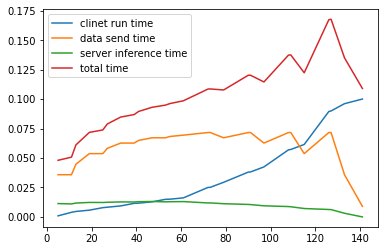

In [114]:
plt.plot(destinations, inference_info, label="clinet run time")
plt.plot(destinations, data_send_info, label="data send time")
plt.plot(destinations, server_infer_info, label="server inference time")
plt.plot(destinations, [i + d + s for i, d, s in zip(inference_info, data_send_info, server_infer_info)], label="total time")
# plt.plot(destinations, np.maximum(inference_info, data_send_info), label="after hiding")
plt.legend(fontsize=10)
plt.show()

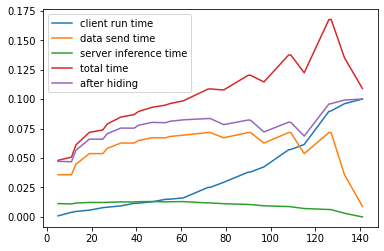

In [115]:
plt.plot(destinations, inference_info, label="client run time")
plt.plot(destinations, data_send_info, label="data send time")
plt.plot(destinations, server_infer_info, label="server inference time")
plt.plot(destinations, [i + d + s for i, d, s in zip(inference_info, data_send_info, server_infer_info)], label="total time")
plt.plot(destinations, [max([i, d]) + s for i, d, s in zip(inference_info, data_send_info, server_infer_info)], label="after hiding")
plt.legend(fontsize=10)
plt.show()